In [1]:
import logging
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from src.datasets import load_census_dataset
from src.shadow_learn import ShadowedSetEstimator
from src.model_selection import grid_search, score_zoom
from src.utils import create_logfile, log_last_execution
from src.plot import plot_shadowed_set

In [2]:
log = False
create_logfile('grid_search_with_pca_two_phases_census', 
              'Started Grid Search with PCA for Gurobi Two Phases Models on census dataset', log)

In [3]:
labels = ['<=50K', '>50K']
label_colors = ['crimson', 'cornflowerblue']

contourf_colors = ['white', 'pink', 'palevioletred', 'red']

In [4]:
estimator = ShadowedSetEstimator(solver='gurobi-two-phases')

## Preliminary explained_variance analysis

In [5]:
X, y, _, _ = load_census_dataset(target='<=50K', target_column='income', length=150)
X.shape

(150, 66)

In [6]:
X

array([[0.000e+00, 0.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        5.500e+01],
       [0.000e+00, 0.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        4.000e+01],
       [0.000e+00, 0.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        5.000e+01],
       ...,
       [0.000e+00, 0.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        4.000e+01],
       [0.000e+00, 0.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        2.400e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.105e+03, 0.000e+00,
        5.000e+01]])

Text(0, 0.5, 'cumulative explained variance')

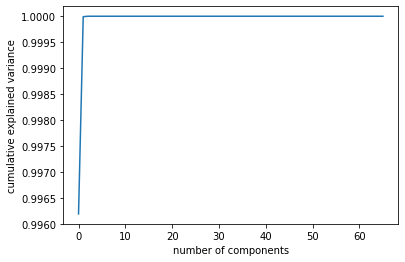

In [7]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [8]:
np.cumsum(pca.explained_variance_ratio_)

array([0.99618947, 0.99999168, 0.99999998, 0.99999999, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [9]:
pca = PCA(0.75).fit(X)
pca.n_components_

1

## <=50K conservative metric GridSearch with PCA dim. reduction

In [10]:
dataset_loader = lambda: load_census_dataset(target='<=50K', target_column='income', length=300)
C0_range = np.concatenate((np.logspace(-1, 1, 5), []))
C1_range = np.concatenate((np.logspace(-1, 1, 5), []))
sigma_range = np.concatenate((np.logspace(-1, 1, 5), [9.44444]))
param_grid = {'C0': C0_range, 'C1': C1_range, 'sigma': sigma_range}

In [11]:
# Done 120 out of 120 | elapsed:  9.6min con 1000 istanze
gs_res = grid_search(dataset_loader, estimator, 'conservative', param_grid, 
                 scaled=True, variance_ratio=0.75, log=log)

***** Split n. 0
Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   20.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  8.1min



--------------------------------------------
--------------------------------------------

Using license file C:\Users\gabri\gurobi.lic
Academic license - for non-commercial use only - expires 2020-12-01


[Parallel(n_jobs=2)]: Done 1500 out of 1500 | elapsed:  9.7min finished


mean_fit_time                                                      0.629543
std_fit_time                                                     0.00741748
mean_score_time                                                   0.0222076
std_score_time                                                  0.000667008
param_estimator__C0                                                     0.1
param_estimator__C1                                                     0.1
param_estimator__sigma                                                   10
params                    {'estimator__C0': 0.1, 'estimator__C1': 0.1, '...
split0_test_score                                                  0.714286
split1_test_score                                                  0.714286
split2_test_score                                                  0.714286
split3_test_score                                                  0.761905
split4_test_score                                                  0.761905
split5_test_

In [12]:
gs_res['best_gs'].best_params_

{'estimator__C0': 0.1, 'estimator__C1': 0.1, 'estimator__sigma': 10.0}

## <=50K conservative metric score charts with fixed C0

In [13]:
C1_range = np.linspace(0.01, 2, 10)
sigma_range = np.linspace(0.1, 15, 10)
param_grid = {'C1': C1_range, 'sigma': sigma_range}

Fitting 10 folds for each of 121 candidates, totalling 1210 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  4.9min
[Parallel(n_jobs=2)]: Done 1210 out of 1210 | elapsed:  7.4min finished


mean_fit_time                                                      0.660431
std_fit_time                                                      0.0060478
mean_score_time                                                   0.0216705
std_score_time                                                  0.000389274
param_estimator__C1                                                     0.1
param_estimator__sigma                                              3.41111
params                    {'estimator__C1': 0.1, 'estimator__sigma': 3.4...
split0_test_score                                                  0.714286
split1_test_score                                                  0.714286
split2_test_score                                                  0.714286
split3_test_score                                                  0.761905
split4_test_score                                                  0.761905
split5_test_score                                                  0.761905
split6_test_

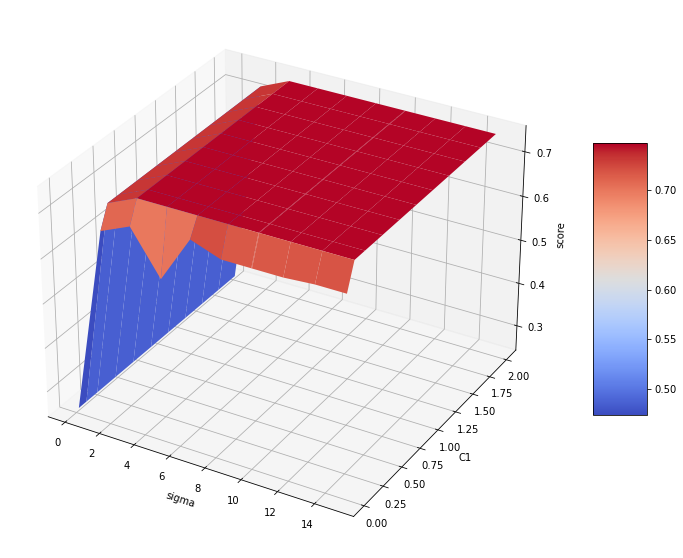

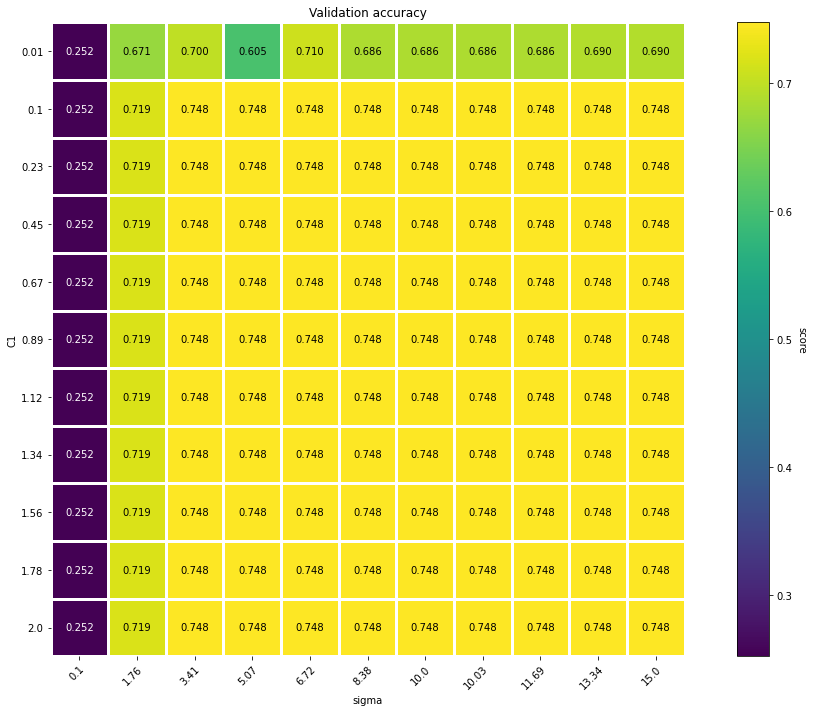

In [14]:
new_gs = score_zoom(gs_res, fixed=['C0'], param_grid=param_grid, log=log)

## <=50K non-conservative metric GridSearch with PCA dim. reduction

In [15]:
dataset_loader = lambda: load_census_dataset(target='<=50K', target_column='income', length=300)
C0_range = np.concatenate((np.logspace(-1, 1, 5), []))
C1_range = np.concatenate((np.logspace(-1, 1, 5), []))
sigma_range = np.concatenate((np.logspace(-1, 1, 5), [9.44444]))
param_grid = {'C0': C0_range, 'C1': C1_range, 'sigma': sigma_range}

In [16]:
gs_res = grid_search(dataset_loader, estimator, 'non-conservative', param_grid, 
                 scaled=True, variance_ratio=0.75, log=log)

***** Split n. 0
Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  8.1min
[Parallel(n_jobs=2)]: Done 1500 out of 1500 | elapsed:  9.8min finished


mean_fit_time                                                      0.633148
std_fit_time                                                     0.00815712
mean_score_time                                                   0.0223448
std_score_time                                                  0.000525299
param_estimator__C0                                                     0.1
param_estimator__C1                                                     0.1
param_estimator__sigma                                                   10
params                    {'estimator__C0': 0.1, 'estimator__C1': 0.1, '...
split0_test_score                                                  0.714286
split1_test_score                                                  0.714286
split2_test_score                                                  0.714286
split3_test_score                                                  0.761905
split4_test_score                                                  0.761905
split5_test_

## <=50K non-conservative metric score charts with fixed C1

In [17]:
C0_range = np.linspace(0.01, 2, 10)
sigma_range = np.linspace(0.1, 15, 10)
param_grid = {'C0': C0_range, 'sigma': sigma_range}

Fitting 10 folds for each of 121 candidates, totalling 1210 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   17.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  4.8min
[Parallel(n_jobs=2)]: Done 1210 out of 1210 | elapsed:  7.4min finished


mean_fit_time                                                     0.761942
std_fit_time                                                    0.00826227
mean_score_time                                                  0.0226404
std_score_time                                                 0.000591137
param_estimator__C0                                                   0.01
param_estimator__sigma                                                 0.1
params                    {'estimator__C0': 0.01, 'estimator__sigma': 0.1}
split0_test_score                                                 0.714286
split1_test_score                                                 0.714286
split2_test_score                                                 0.714286
split3_test_score                                                 0.761905
split4_test_score                                                 0.761905
split5_test_score                                                 0.761905
split6_test_score        

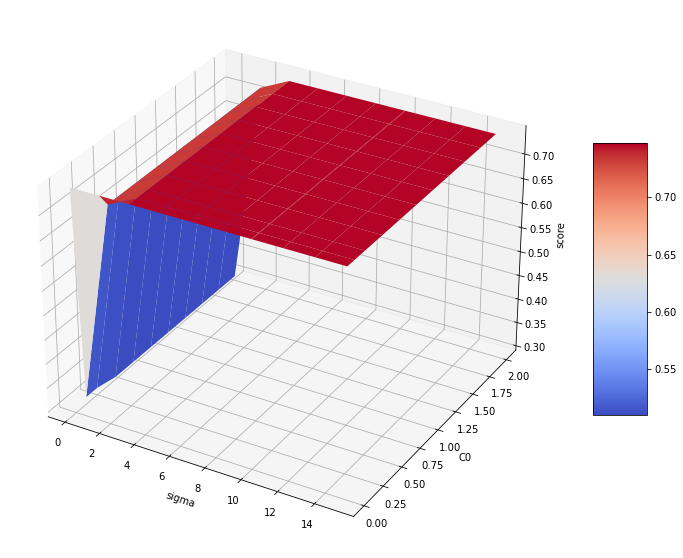

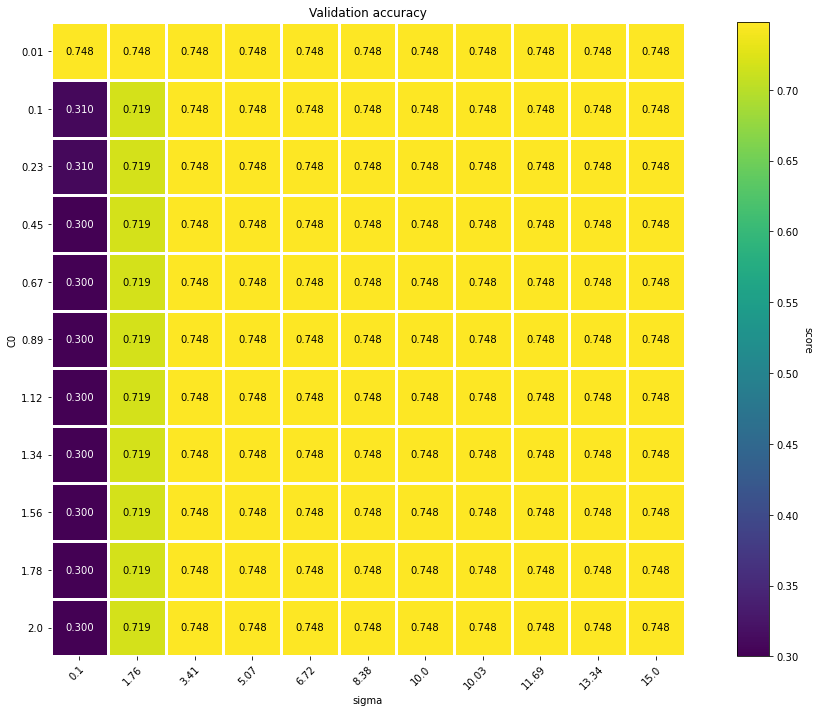

In [18]:
new_gs = score_zoom(gs_res, fixed=['C1'], param_grid=param_grid, log=log)

## >50K conservative metric GridSearch with PCA dim. reduction

In [19]:
dataset_loader = lambda: load_census_dataset(target='>50K', target_column='income', length=300)
C0_range = np.concatenate((np.logspace(-1, 1, 5), []))
C1_range = np.concatenate((np.logspace(-1, 1, 5), []))
sigma_range = np.concatenate((np.logspace(-1, 1, 5), [3.41111]))
param_grid = {'C0': C0_range, 'C1': C1_range, 'sigma': sigma_range}

In [20]:
gs = grid_search(dataset_loader, estimator, 'conservative', param_grid, 
                 scaled=True, variance_ratio=0.75, log=log)

***** Split n. 0
Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    7.6s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   34.7s
[Parallel(n_jobs=2)]: Done 888 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 1500 out of 1500 | elapsed:  2.2min finished


mean_fit_time                                                      0.144216
std_fit_time                                                     0.00328279
mean_score_time                                                  0.00795593
std_score_time                                                  0.000436806
param_estimator__C0                                                     0.1
param_estimator__C1                                                     0.1
param_estimator__sigma                                              3.41111
params                    {'estimator__C0': 0.1, 'estimator__C1': 0.1, '...
split0_test_score                                                  0.761905
split1_test_score                                                  0.571429
split2_test_score                                                  0.761905
split3_test_score                                                  0.857143
split4_test_score                                                  0.809524
split5_test_

## >50K conservative metric score charts with fixed C0

In [21]:
C1_range = np.linspace(0.01, 2, 10)
sigma_range = np.linspace(0.1, 15, 10)
param_grid = {'C1': C1_range, 'sigma': sigma_range}

Fitting 10 folds for each of 121 candidates, totalling 1210 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  4.9min
[Parallel(n_jobs=2)]: Done 1210 out of 1210 | elapsed:  7.4min finished


mean_fit_time                                                      0.679575
std_fit_time                                                      0.0134778
mean_score_time                                                   0.0231017
std_score_time                                                   0.00153171
param_estimator__C1                                                     0.1
param_estimator__sigma                                              3.41111
params                    {'estimator__C1': 0.1, 'estimator__sigma': 3.4...
split0_test_score                                                  0.714286
split1_test_score                                                  0.714286
split2_test_score                                                  0.714286
split3_test_score                                                  0.761905
split4_test_score                                                  0.761905
split5_test_score                                                  0.761905
split6_test_

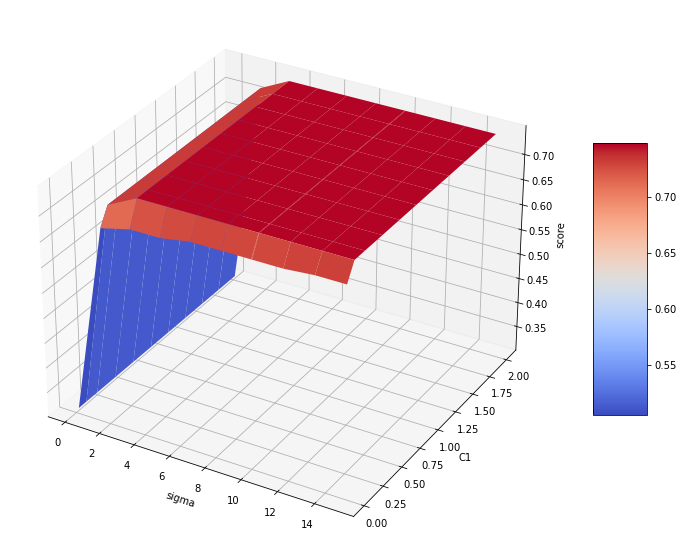

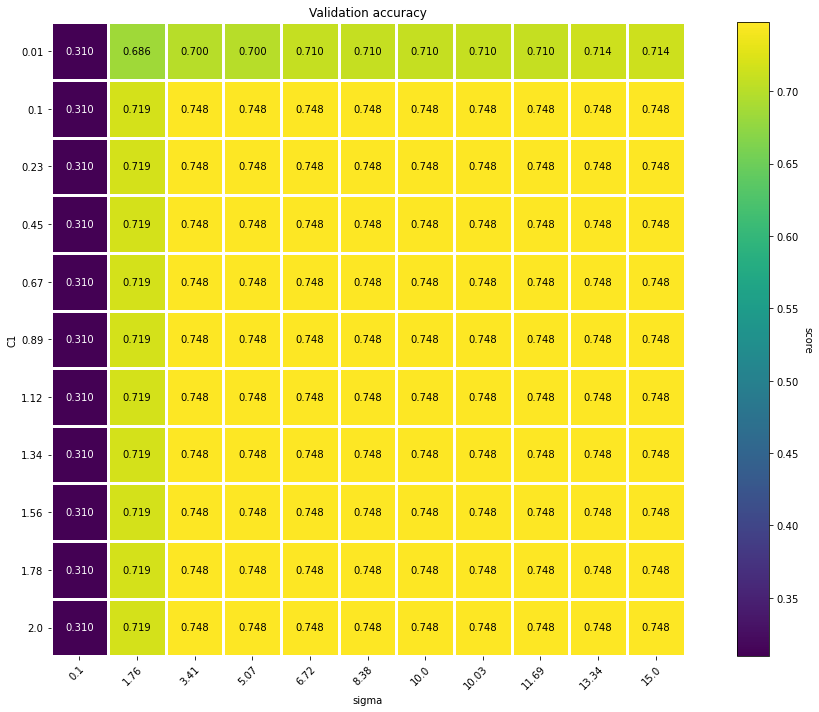

In [22]:
new_gs = score_zoom(gs_res, fixed=['C0'], param_grid=param_grid, log=log)

## >50K non-conservative metric GridSearch with PCA dim. reduction

In [23]:
dataset_loader = lambda: load_census_dataset(target='>50K', target_column='income', length=300)
C0_range = np.concatenate((np.logspace(-1, 1, 5), []))
C1_range = np.concatenate((np.logspace(-1, 1, 5), []))
sigma_range = np.concatenate((np.logspace(-1, 1, 5), [9.44444]))
param_grid = {'C0': C0_range, 'C1': C1_range, 'sigma': sigma_range}

In [24]:
gs_res = grid_search(dataset_loader, estimator, 'non-conservative', param_grid, 
                 scaled=True, variance_ratio=0.75, log=log)

***** Split n. 0
Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    7.1s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   31.3s
[Parallel(n_jobs=2)]: Done 888 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 1500 out of 1500 | elapsed:  2.0min finished


mean_fit_time                                                      0.150275
std_fit_time                                                     0.00263091
mean_score_time                                                  0.00810397
std_score_time                                                  0.000623446
param_estimator__C0                                                     0.1
param_estimator__C1                                                     0.1
param_estimator__sigma                                                  0.1
params                    {'estimator__C0': 0.1, 'estimator__C1': 0.1, '...
split0_test_score                                                  0.761905
split1_test_score                                                  0.714286
split2_test_score                                                  0.761905
split3_test_score                                                  0.761905
split4_test_score                                                  0.761905
split5_test_

## >50K non-conservative metric score charts with fixed C1

In [25]:
C0_range = np.linspace(0.01, 2, 10)
sigma_range = np.linspace(0.1, 10, 10)
param_grid = {'C0': C0_range, 'sigma': sigma_range}

Fitting 10 folds for each of 121 candidates, totalling 1210 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    6.9s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   30.0s
[Parallel(n_jobs=2)]: Done 888 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 1210 out of 1210 | elapsed:  1.6min finished


mean_fit_time                                                     0.148499
std_fit_time                                                    0.00385846
mean_score_time                                                 0.00819781
std_score_time                                                 0.000467445
param_estimator__C0                                                   0.01
param_estimator__sigma                                                 0.1
params                    {'estimator__C0': 0.01, 'estimator__sigma': 0.1}
split0_test_score                                                 0.761905
split1_test_score                                                 0.714286
split2_test_score                                                 0.761905
split3_test_score                                                 0.761905
split4_test_score                                                 0.714286
split5_test_score                                                 0.857143
split6_test_score        

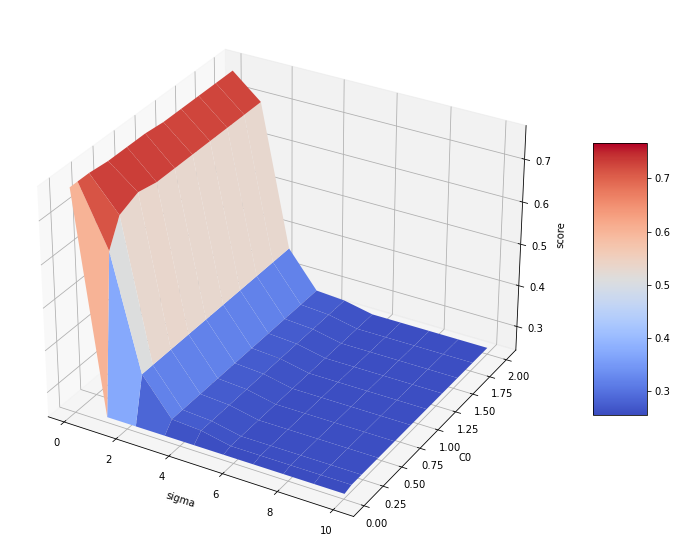

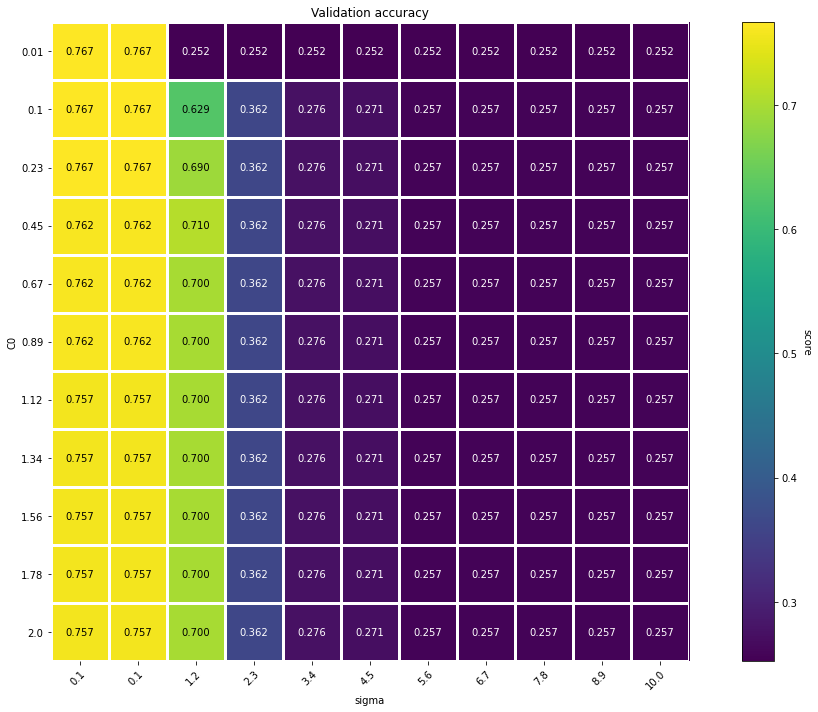

In [26]:
new_gs = score_zoom(gs_res, fixed=['C1'], param_grid=param_grid, log=log)

In [27]:
log_last_execution('Finished Grid Search with PCA for Gurobi Two Phases Models on census dataset', log)

Last complete execution: 2020-11-18 18:41:13
